# ADS 509 Assignment 5.1: Topic Modeling

This notebook holds Assignment 5.1 for Module 5 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In this assignment you will work with a categorical corpus that accompanies `nltk`. You will build the three types of topic models described in Chapter 8 of _Blueprints for Text Analytics using Python_: NMF, LSA, and LDA. You will compare these models to the true categories. 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [1]:
# These libraries may be useful to you

# !pip install pyLDAvis==3.4.1 --user  #You need to restart the Kernel after installation.
# You also need a Python version => 3.9.0
from nltk.corpus import brown

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import pyLDAvis
import pyLDAvis.lda_model
import pyLDAvis.gensim_models

import spacy
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation

from spacy.lang.en.stop_words import STOP_WORDS as stopwords

from collections import Counter, defaultdict

nlp = spacy.load('en_core_web_sm')

In [2]:
# add any additional libaries you need here


In [3]:
# This function comes from the BTAP repo.

def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]]*100.0/total)))

## Getting to Know the Brown Corpus

Let's spend a bit of time getting to know what's in the Brown corpus, our NLTK example of an "overlapping" corpus.

In [4]:
# categories of articles in Brown corpus
for category in brown.categories() :
    print(f"For {category} we have {len(brown.fileids(categories=category))} articles.")

For adventure we have 29 articles.
For belles_lettres we have 75 articles.
For editorial we have 27 articles.
For fiction we have 29 articles.
For government we have 30 articles.
For hobbies we have 36 articles.
For humor we have 9 articles.
For learned we have 80 articles.
For lore we have 48 articles.
For mystery we have 24 articles.
For news we have 44 articles.
For religion we have 17 articles.
For reviews we have 17 articles.
For romance we have 29 articles.
For science_fiction we have 6 articles.


Let's create a dataframe of the articles in of hobbies, editorial, government, news, and romance.

In [5]:
categories = ['editorial','government','news','romance','hobbies'] 

category_list = []
file_ids = []
texts = []

for category in categories : 
    for file_id in brown.fileids(categories=category) :
        
        # build some lists for a dataframe
        category_list.append(category)
        file_ids.append(file_id)
        
        text = brown.words(fileids=file_id)
        texts.append(" ".join(text))

        
        
df = pd.DataFrame()
df['category'] = category_list
df['id'] = file_ids
df['text'] = texts 

df.shape

(166, 3)

In [6]:
# Let's add some helpful columns on the df
df['char_len'] = df['text'].apply(len)
df['word_len'] = df['text'].apply(lambda x: len(x.split()))


<Axes: xlabel='category'>

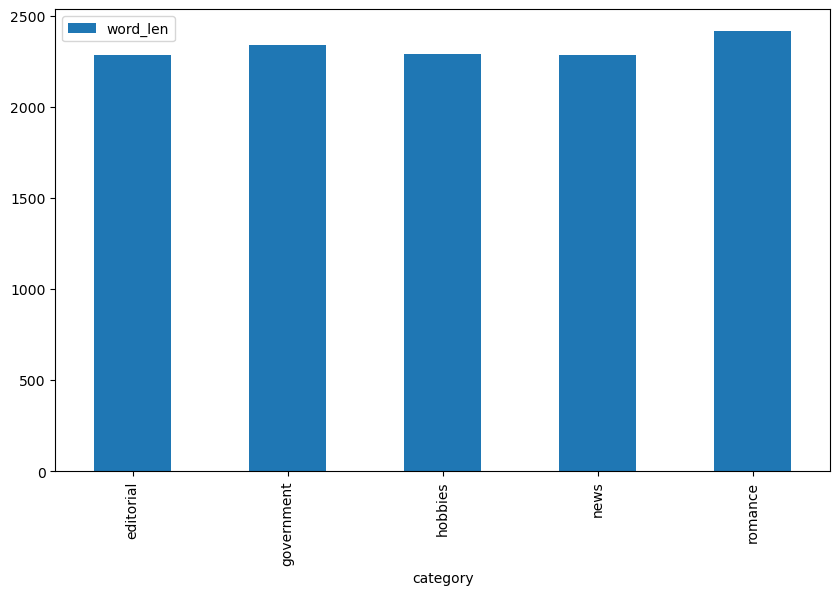

In [7]:
%matplotlib inline
df.groupby('category').agg({'word_len': 'mean'}).plot.bar(figsize=(10,6))

Now do our TF-IDF and Count vectorizations.

In [8]:
count_text_vectorizer = CountVectorizer(stop_words=list(stopwords), min_df=5, max_df=0.7)
count_text_vectors = count_text_vectorizer.fit_transform(df["text"])
count_text_vectors.shape

/opt/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


(166, 4941)

In [9]:
tfidf_text_vectorizer = TfidfVectorizer(stop_words=list(stopwords), min_df=5, max_df=0.7)
tfidf_text_vectors = tfidf_text_vectorizer.fit_transform(df['text'])
tfidf_text_vectors.shape

(166, 4941)

Q: What do the two data frames `count_text_vectors` and `tfidf_text_vectors` hold? 

A: count_text_vectors holds the number of times each word appears in each document after removing stopwords, tfidf_text_vectors holds TF-IDF scores, which reflect how important a word is to a document relative to the whole corpus. 

## Fitting a Non-Negative Matrix Factorization Model

In this section the code to fit a five-topic NMF model has already been written. This code comes directly from the [BTAP repo](https://github.com/blueprints-for-text-analytics-python/blueprints-text), which will help you tremendously in the coming sections. 

In [10]:
nmf_text_model = NMF(n_components=5, random_state=314)
W_text_matrix = nmf_text_model.fit_transform(tfidf_text_vectors)
H_text_matrix = nmf_text_model.components_

In [11]:
display_topics(nmf_text_model, tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  mr (0.51)
  president (0.45)
  kennedy (0.43)
  united (0.42)
  khrushchev (0.40)

Topic 01
  said (0.88)
  didn (0.46)
  ll (0.45)
  thought (0.42)
  man (0.37)

Topic 02
  state (0.39)
  development (0.36)
  tax (0.33)
  sales (0.30)
  program (0.25)

Topic 03
  mrs (2.61)
  mr (0.78)
  said (0.63)
  miss (0.52)
  car (0.51)

Topic 04
  game (1.02)
  league (0.74)
  ball (0.72)
  baseball (0.71)
  team (0.66)


Now some work for you to do. Compare the NMF factorization to the original categories from the Brown Corpus.

We are interested in the extent to which our NMF factorization agrees or disagrees with the original categories in the corpus. For each topic in your NMF model, tally the Brown categories and interpret the results. 


In [12]:
# Your code here
df['nmf_topic'] = W_text_matrix.argmax(axis=1)
topic_category_counts = df.groupby(['nmf_topic', 'category']).size().unstack(fill_value=0)
topic_category_counts

category,editorial,government,hobbies,news,romance
nmf_topic,,,,,
0,20,4,0,8,0
1,4,0,8,0,29
2,2,26,26,11,0
3,0,0,1,17,0
4,1,0,1,8,0


Q: How does your five-topic NMF model compare to the original Brown categories? 

A: The model shows some alignment with the original brown categories, but it also has some redundancy and overlap. Topic 1 strongly captures the romance category with 29 documents, though it also includes 12 from editorial and hobbies. Topic 0 mainly aligns with editorial (20 documents) but also includes 12 from government and news. Topic 2 has the documents mainly spread across in government, hobbies, and news categories. So Topics 0-2 do show some overlap between categories. Topics 3 and 4 both capture news documents (17 and 8, respectively), which is redundant because both are modeling similar content. So overall the model seems to struggle in cleanly separating the documents.

## Fitting an LSA Model

In this section, follow the example from the repository and fit an LSA model (called a "TruncatedSVD" in `sklearn`). Again fit a five-topic model and compare it to the actual categories in the Brown corpus. Use the TF-IDF vectors for your fit, as above. 

To be explicit, we are once again interested in the extent to which this LSA factorization agrees or disagrees with the original categories in the corpus. For each topic in your model, tally the Brown categories and interpret the results. 


In [13]:
lsa_model = TruncatedSVD(n_components=5, random_state=314)
W_lsa_matrix = lsa_model.fit_transform(tfidf_text_vectors)
H_lsa_matrix = lsa_model.components_

In [14]:
df['lsa_topic'] = W_lsa_matrix.argmax(axis=1)
lsa_topic_category_counts = df.groupby(['lsa_topic', 'category']).size().unstack(fill_value=0)
lsa_topic_category_counts

category,editorial,government,hobbies,news,romance
lsa_topic,,,,,
0,27,30,36,34,21
1,0,0,0,0,8
3,0,0,0,3,0
4,0,0,0,7,0


Q: How does your five-topic LSA model compare to the original Brown categories? 

A: The model shows poor alignment with the original categories. Most of the documents were assigned to Topic 0 and only as small number of documents were assigned to Topics 1, 3, and 4, and Topic 2 did not receive any assignments at all.

In [15]:
# call display_topics on your model
display_topics(lsa_model, tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  said (0.44)
  mr (0.25)
  mrs (0.22)
  state (0.20)
  man (0.17)

Topic 01
  said (3.89)
  ll (2.73)
  didn (2.63)
  thought (2.20)
  got (1.97)

Topic 02
  mrs (3.12)
  mr (1.70)
  said (1.06)
  kennedy (0.82)
  khrushchev (0.77)

Topic 03
  mrs (29.45)
  club (6.53)
  game (6.12)
  jr (5.60)
  university (5.20)

Topic 04
  game (4.54)
  league (3.27)
  baseball (3.22)
  ball (3.10)
  team (2.94)


Q: What is your interpretation of the display topics output? 

A: The LSA model shows some recognizable themes but with noticeable overlap. Topics 0 and 1 reflect general narrative or conversational language, with frequent words like “said,” “mr,” and “thought.” Topic 2 suggests political content, with terms like “kennedy” and “khrushchev.” Topic 3 appears social or academic, while Topic 4 is clearly sports-related. The repetition of words like “said” and “mrs” across topics indicates less distinct separation compared to the NMF model.

## Fitting an LDA Model

Finally, fit a five-topic LDA model using the count vectors (`count_text_vectors` from above). Display the results using `pyLDAvis.display` and describe what you learn from that visualization. 

In [16]:
# Fit your LDA model here
lda_text_model = LatentDirichletAllocation(n_components=5, random_state=314)
lda_text_model.fit(count_text_vectors)
W_lda_matrix = lda_text_model.transform(count_text_vectors)
H_lda_matrix = lda_text_model.components_

In [17]:
# Call `display_topics` on your fitted model here
display_topics(lda_text_model, count_text_vectorizer.get_feature_names_out())


Topic 00
  said (1.05)
  mrs (0.82)
  little (0.56)
  good (0.51)
  way (0.50)

Topic 01
  state (0.67)
  development (0.63)
  000 (0.57)
  program (0.48)
  business (0.44)

Topic 02
  said (1.18)
  mr (0.72)
  president (0.51)
  city (0.43)
  state (0.37)

Topic 03
  feed (0.55)
  college (0.54)
  general (0.44)
  university (0.43)
  work (0.37)

Topic 04
  states (1.14)
  state (1.02)
  united (0.84)
  shall (0.66)
  government (0.61)


In [18]:
df['lda_topic'] = W_lda_matrix.argmax(axis=1)
lda_topic_category_counts = df.groupby(['lda_topic', 'category']).size().unstack(fill_value=0)
lda_topic_category_counts

category,editorial,government,hobbies,news,romance
lda_topic,,,,,
0,3,1,11,4,28
1,1,12,9,3,0
2,21,3,2,32,1
3,2,4,8,3,0
4,0,10,6,2,0


Q: What inference do you draw from the displayed topics for your LDA model? 

A: The LDA model shows a few clear themes. Topic 0 seems conversational, with words like “said” and “mrs.” Topic 1 relates to business or development, while Topic 2 mixes political and narrative terms. Topic 3 appears academic, with words like “college” and “university,” and Topic 4 is focused on government. Some terms like “said” and “state” appear in multiple topics, showing a bit of overlap.

Q: Repeat the tallying of Brown categories within your topics. How does your five-topic LDA model compare to the original Brown categories? 

A: Most topics include a mix of documents from multiple categories. Topic 0 has 28 romance documents, but 19 from other categories. Topic 1 has 12 government documents, with 13 spread across others. Topic 2 stands out with 21 editorial and 32 news documents, but still lacks a single dominant category. Overall, the LDA model does not show strong category separation, with most topics blending multiple sources.

In [19]:
lda_display = pyLDAvis.lda_model.prepare(lda_text_model, count_text_vectors, count_text_vectorizer, sort_topics=False)

In [20]:
pyLDAvis.display(lda_display)

Q: What conclusions do you draw from the visualization above? Please address the principal component scatterplot and the salient terms graph.

A: In the principal component scatterplot, Topic 3 is the most central and has the largest area, indicating it covers a broad range of documents. Topics 4 and 2 are close together, hinting at some thematic similarity, while Topics 1 and 5 are farthest apart and maintain good separation from all others.

Looking at the salient terms graphs, Topic 1 stands out for its narrative vocabulary, including “said,” “mrs,” and “little,” which contrasts clearly with the more institutional, academic, or political terms in Topics 2 through 5. When Topic 1 dominates in frequency, its circle in the plot becomes larger, and the others shrink and vice versa. This inverse relationship in circle size suggests that Topic 1 often dominates certain documents, while others are more evenly shared among the remaining topics.